# Scale Detection
Train a model to detect the scale of an image relative to the scale of the training dataset for a model.

In [1]:
import os
import errno
import functools

import numpy as np
import tensorflow as tf

import deepcell

/usr/local/lib/python3.5/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


## Generate all label dataset
Download HeLa data for nuclear, brightfield and fluorescent cytoplasm

In [5]:
from deepcell.datasets import hela_s3, phase, cytoplasm

nuc_train, nuc_test = hela_s3.load_data()
brtfld_train, brtfld_test = phase.HeLa_S3.load_data()
flr_train, flr_test = cytoplasm.hela_s3.load_data()

### Flatten All Datasets into 2D and Combine

In [6]:
from deepcell.utils.data_utils import reshape_matrix

RESHAPE_SIZE = 216

for train, test in zip([nuc_train, brtfld_train, flr_train], 
                       [nuc_test, brtfld_test, flr_test]):
    train['X'], train['y'] = reshape_matrix(train['X'], train['y'], RESHAPE_SIZE)
    test['X'], test['y'] = reshape_matrix(test['X'], test['y'], RESHAPE_SIZE)

Reshaped feature data from (6480, 216, 256, 1) to (6480, 216, 216, 1)
Reshaped training data from (6480, 216, 256, 1) to (6480, 216, 216, 1)
Reshaped feature data from (720, 216, 256, 1) to (720, 216, 216, 1)
Reshaped training data from (720, 216, 256, 1) to (720, 216, 216, 1)
Reshaped feature data from (576, 512, 512, 1) to (5184, 216, 216, 1)
Reshaped training data from (576, 512, 512, 1) to (5184, 216, 216, 1)
Reshaped feature data from (64, 512, 512, 1) to (576, 216, 216, 1)
Reshaped training data from (64, 512, 512, 1) to (576, 216, 216, 1)
Reshaped feature data from (576, 512, 512, 1) to (5184, 216, 216, 1)
Reshaped training data from (576, 512, 512, 1) to (5184, 216, 216, 1)
Reshaped feature data from (64, 512, 512, 1) to (576, 216, 216, 1)
Reshaped training data from (64, 512, 512, 1) to (576, 216, 216, 1)


In [7]:
# Stack up our data as train and test
X_train = np.vstack([nuc_train['X'], brtfld_train['X'], flr_train['X']])
y_train = np.vstack([nuc_train['y'], brtfld_train['y'], flr_train['y']])

X_test = np.vstack([nuc_test['X'], brtfld_test['X'], flr_test['X']])
y_test = np.vstack([nuc_test['y'], brtfld_test['y'], flr_test['y']])

In [8]:
# Load the data into a tensors as X and y
X = np.vstack([X_train, X_test])
y = np.vstack([y_train, y_test])

In [9]:
# Set up filepath constants

# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.getcwd() #os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# filename to write combined data
filename = 'HeLa-mixed-labels.npz'

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# the path to the data file is currently required for `train_model_()` functions
np.savez(DATA_FILE, X=X, y=y)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

## Define data generator

In [9]:
from tensorflow.python.keras.preprocessing.image import Iterator
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import array_to_img
from tensorflow.python.keras import backend as K
import numpy as np


class ScaleIterator(Iterator):
    """Iterator yielding data from Numpy arrayss (`X and `y`).

    Args:
        train_dict: dictionary consisting of numpy arrays for `X` and `y`.
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
    """

    def __init__(self,
                 train_dict,
                 scale_generator,
                 batch_size=1,
                 skip=None,
                 shuffle=False,
                 transform=None,
                 transform_kwargs={},
                 seed=None,
                 data_format='channels_last',
                 save_to_dir=None,
                 save_prefix='',
                 save_format='png'):
        X, y = train_dict['X'], train_dict['y']
        if X.shape[0] != y.shape[0]:
            raise ValueError('Training batches and labels should have the same'
                             'length. Found X.shape: {} y.shape: {}'.format(
                                 X.shape, y.shape))
        self.x = np.asarray(X, dtype=K.floatx())

        if self.x.ndim != 4:
            raise ValueError('Input data in `ImageFullyConvIterator` '
                             'should have rank 4. You passed an array '
                             'with shape', self.x.shape)

        self.y = np.ones((self.x.shape[0],1), dtype=K.floatx())
        self.channel_axis = 3 if data_format == 'channels_last' else 1
        self.skip = skip
        self.scale_generator = scale_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(ScaleIterator, self).__init__(
            self.x.shape[0], batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros(tuple([len(index_array)] + list(self.x.shape)[1:]))
        batch_y = np.zeros(tuple([len(index_array)] + list(self.y.shape)[1:]))

        for i, j in enumerate(index_array):
            x = self.x[j]
            x, y = self.scale_generator.random_transform(x.astype(K.floatx()))

            x = self.scale_generator.standardize(x)

            batch_x[i] = x
            batch_y[i] = y

        if self.save_to_dir:
            for i, j in enumerate(index_array):
                if self.data_format == 'channels_first':
                    img_x = np.expand_dims(batch_x[i, 0, ...], 0)
                else:
                    img_x = np.expand_dims(batch_x[i, ..., 0], -1)
                img = array_to_img(img_x, self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(
                    prefix=self.save_prefix,
                    index=j,
                    hash=np.random.randint(1e4),
                    format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))

        return batch_x, batch_y

    def next(self):
        """For python 2.x. Returns the next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)

class ScaleDataGenerator(ImageDataGenerator):
    """Generates batches of tensor image data with real-time data augmentation.
    The data will be looped over (in batches).

    Args:
        featurewise_center: boolean, set input mean to 0 over the dataset,
            feature-wise.
        samplewise_center: boolean, set each sample mean to 0.
        featurewise_std_normalization: boolean, divide inputs by std
            of the dataset, feature-wise.
        samplewise_std_normalization: boolean, divide each input by its std.
        zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
        zca_whitening: boolean, apply ZCA whitening.
        rotation_range: int, degree range for random rotations.
        width_shift_range: float, 1-D array-like or int
            float: fraction of total width, if < 1, or pixels if >= 1.
            1-D array-like: random elements from the array.
            int: integer number of pixels from interval
                `(-width_shift_range, +width_shift_range)`
            With `width_shift_range=2` possible values are ints [-1, 0, +1],
            same as with `width_shift_range=[-1, 0, +1]`,
            while with `width_shift_range=1.0` possible values are floats in
            the interval [-1.0, +1.0).
        shear_range: float, shear Intensity
            (Shear angle in counter-clockwise direction in degrees)
        zoom_range: float or [lower, upper], Range for random zoom.
            If a float, `[lower, upper] = [1-zoom_range, 1+zoom_range]`.
        channel_shift_range: float, range for random channel shifts.
        fill_mode: One of {"constant", "nearest", "reflect" or "wrap"}.
            Default is 'nearest'. Points outside the boundaries of the input
            are filled according to the given mode:
                'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
                'nearest':  aaaaaaaa|abcd|dddddddd
                'reflect':  abcddcba|abcd|dcbaabcd
                'wrap':  abcdabcd|abcd|abcdabcd
        cval: float or int, value used for points outside the boundaries
            when `fill_mode = "constant"`.
        horizontal_flip: boolean, randomly flip inputs horizontally.
        vertical_flip: boolean, randomly flip inputs vertically.
        rescale: rescaling factor. Defaults to None. If None or 0, no rescaling
            is applied, otherwise we multiply the data by the value provided
            (before applying any other transformation).
        preprocessing_function: function that will be implied on each input.
            The function will run after the image is resized and augmented.
            The function should take one argument:
            one image (Numpy tensor with rank 3),
            and should output a Numpy tensor with the same shape.
        data_format: One of {"channels_first", "channels_last"}.
            "channels_last" mode means that the images should have shape
                `(samples, height, width, channels)`,
            "channels_first" mode means that the images should have shape
                `(samples, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
                Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
        validation_split: float, fraction of images reserved for validation
            (strictly between 0 and 1).
    """

    def flow(self,
             train_dict,
             batch_size=1,
             skip=None,
             transform=None,
             transform_kwargs={},
             shuffle=True,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png'):
        """Generates batches of augmented/normalized data with given arrays.

        Args:
            train_dict: dictionary of X and y tensors. Both should be rank 4.
            batch_size: int (default: 1).
            shuffle: boolean (default: True).
            seed: int (default: None).
            save_to_dir: None or str (default: None).
                This allows you to optionally specify a directory
                to which to save the augmented pictures being generated
                (useful for visualizing what you are doing).
            save_prefix: str (default: `''`). Prefix to use for filenames of
                saved pictures (only relevant if `save_to_dir` is set).
            save_format: one of "png", "jpeg". Default: "png".
                (only relevant if `save_to_dir` is set)

        Returns:
            An Iterator yielding tuples of `(x, y)` where `x` is a numpy array
            of image data and `y` is a numpy array of labels of the same shape.
        """
        return ScaleIterator(
            train_dict,
            self,
            batch_size=batch_size,
            transform=transform,
            transform_kwargs=transform_kwargs,
            skip=skip,
            shuffle=shuffle,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)

    def random_transform(self, x, y=None, seed=None):
        """Applies a random transformation to an image.

        Args:
            x: 3D tensor or list of 3D tensors,
                single image.
            y: 3D tensor or list of 3D tensors,
                label mask(s) for `x`, optional.
            seed: Random seed.

        Returns:
            A randomly transformed version of the input (same shape).
            If `y` is passed, it is transformed if necessary and returned.
        """
        params = self.get_random_transform(x.shape, seed)
        params['zy'] = params['zx']

        if isinstance(x, list):
            x = [self.apply_transform(x_i, params) for x_i in x]
        else:
            x = self.apply_transform(x, params)
        
        y = np.ones(1)
        y[0] = params['zx']

        return x, y

## Define model

In [10]:
from tensorflow.python.keras.layers import Input, AveragePooling2D, Flatten, Activation
from deepcell.layers import ImageNormalization2D, TensorProduct
from tensorflow.python.keras.models import Sequential, Model
from deepcell.utils.backbone_utils import get_backbone

def scale_model(input_shape=(None, None, 1),
                inputs=None,
                backbone='VGG16',
                use_imagenet=True,
                required_channels=3,
                norm_method='whole_image',
                pooling=None):
    if inputs is None:
        inputs = Input(shape=input_shape)
    
    norm = ImageNormalization2D(norm_method=norm_method)(inputs)
    fixed_inputs = TensorProduct(required_channels)(norm)
    
    # force the input shape
    fixed_input_shape = list(input_shape)
    fixed_input_shape[-1] = required_channels
    fixed_input_shape = tuple(fixed_input_shape)

    model_kwargs = {
        'include_top': False,
        'weights': None,
        'input_shape': fixed_input_shape,
        'pooling': pooling
    }
    
    backbone = get_backbone(backbone, fixed_inputs, use_imagenet=use_imagenet, return_dict=False, **model_kwargs)
    
    backbone_inputs = backbone.inputs
    backbone_outputs = backbone.outputs[0]
        
    new_model_inputs = backbone_inputs
    x = AveragePooling2D(4)(backbone_outputs)
    x = TensorProduct(256)(x)
    x = TensorProduct(1)(x)
    x = Flatten()(x)
    new_model_outputs = Activation('relu')(x)
    
    new_model = Model(inputs=new_model_inputs, outputs=new_model_outputs)
    
    return new_model

In [12]:
trial_model = scale_model(input_shape=(216,216,1))
trial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 216, 216, 1)       0         
_________________________________________________________________
image_normalization2d (Image (None, 216, 216, 1)       3721      
_________________________________________________________________
tensor_product (TensorProduc (None, 216, 216, 3)       6         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 216, 216, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 216, 216, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 108, 108, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 108, 108, 128)     73856     
__________

In [13]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 20  # Number of training epochs
lr = 1e-5
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)
batch_size = 4

trial_model.compile(optimizer, loss='MSE')

In [16]:
model_path = '/notebooks/data/ScaleDetection-helaMultiLabelv3.h5'

In [ ]:
# Prepare training data
train_dict = {}
train_dict['X'] = X_train
train_dict['y'] = y_train

gen = ScaleDataGenerator(rotation_range=180,
                        horizontal_flip=True,
                        vertical_flip=True,
                        zoom_range=(0.5, 2))

train_data = gen.flow(train_dict)

In [17]:
from tensorflow.python.keras import callbacks

trial_model.fit_generator(train_data, 
                          steps_per_epoch=train_data.y.shape[0]//batch_size,
                          epochs=n_epoch,
                          callbacks=[
                            callbacks.LearningRateScheduler(lr_sched),
                            callbacks.ModelCheckpoint(
                                model_path, verbose=1, period=5)
                        ])
trial_model.save(model_path)

Epoch 1/20
4212/4212 [==============================] - 137s 32ms/step - loss: 0.0296
Epoch 2/20
4212/4212 [==============================] - 132s 31ms/step - loss: 0.0036
Epoch 3/20
4212/4212 [==============================] - 132s 31ms/step - loss: 0.0024
Epoch 4/20
4212/4212 [==============================] - 132s 31ms/step - loss: 0.0019
Epoch 5/20
4211/4212 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 00005: saving model to /notebooks/data/ScaleDetection-helaMultiLabelv3.h5
4212/4212 [==============================] - 133s 31ms/step - loss: 0.0018
Epoch 6/20
4212/4212 [==============================] - 132s 31ms/step - loss: 0.0015
Epoch 7/20
4212/4212 [==============================] - 132s 31ms/step - loss: 0.0014
Epoch 8/20
4212/4212 [==============================] - 132s 31ms/step - loss: 0.0012
Epoch 9/20
4212/4212 [==============================] - 132s 31ms/step - loss: 0.0010
Epoch 10/20
4211/4212 [============================>.] - ETA: 0s - loss: 9.649

## Test model predictions

In [21]:
gen3 = ScaleDataGenerator(rotation_range=180,
                        horizontal_flip=True,
                        vertical_flip=True,
                        zoom_range=(0.5, 2))

test_data = gen3.flow(test_dict)

true,pred = [],[]
for i in range(500):
    X,y = test_data.next()
    true.append(y)
    pred.append(trial_model.predict(X))
    
true = np.array(true)
pred = np.array(pred)

Text(0.5, 0, 'True Zoom')

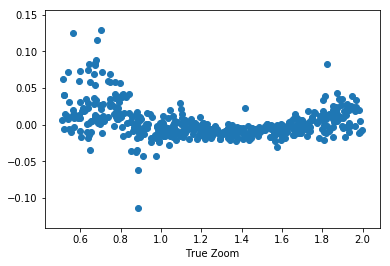

In [25]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.scatter(true,pred-true)
ax.set_xlabel('True Zoom')
ax.set_ylabel('Error')